**<span style="color:#0638b2; font-size:32px">
Phase II - Model Fine Tuning and Saving w/ Combined Dataset
</span>** <br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers, regularizers   ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
## Import EFB3 Model Weights
from tensorflow.keras.applications import EfficientNetB3

import pathlib
import zipfile

2024-12-07 14:43:58.859694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 14:43:59.057051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 14:43:59.107320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 14:43:59.515113: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.getcwd()

'/sfs/gpfs/tardis/home/rrm3nh/ds6050/DS6050_Project'

**<span style="color:#180842; font-size:26px">
Train/Validation Data Pull
</span>** <br>

In [3]:
# Specify the path to the zip file
# dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1" ## CAS only data.
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/sy3duklriddl3fo668as8/ls_model_data_six_combined_v2.zip?rlkey=chgywsbsn3ny0m2vrllll8icx&dl=0?raw=1" 

In [4]:
data_dir = tf.keras.utils.get_file('ls_model_data_six_combined_v2.zip', origin=dataset_url, extract=True)
data_dir = data_dir.strip(".zip") + "_extracted" # it appears that TensorFlow 2.17 get_file appends "_extracted" to zip files
data_dir = pathlib.Path(data_dir)#.with_suffix('')


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

7132


In [6]:
# Drill into each subdirectory and list counts per folder
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslide':
landslide: 3115 .jpg images

Contents of folder 'non_landslide':
non_landslide: 4017 .jpg images


**<span style="color:#180842; font-size:26px">
Test Data Pull
</span>** <br>

In [7]:
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
# test_dataset_url = "https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1"
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/kl3e9wxoibqu0ldogwxg0/test_google_images_landslides_five.zip?rlkey=zuhh6xvjy3oi9wuroy4ogtdi3&dl=0?raw=1"

test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/a8evtoop10e9cadnxorqw/google_earth_unique_test.zip?rlkey=g463zbw32hn5ez80wb1qogw4g&dl=0?raw=1"

In [8]:
data_dir_test = tf.keras.utils.get_file('google_earth_unique_test.zip', origin=test_dataset_url, extract=True)
data_dir_test = data_dir_test.strip(".zip") + "_extracted" # it appears that TensorFlow 2.17 get_file appends "_extracted" to zip files
data_dir_test = pathlib.Path(data_dir_test)#.with_suffix('')

In [9]:
## Review folders in incoming data / classes
folders_test = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_test:
    print(folder.name)

Folders in the test directory:
landslides
non-landslides


In [10]:
# Drill into each subdirectory and list counts per folder
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslides':
landslides: 31 .jpg images

Contents of folder 'non-landslides':
non-landslides: 31 .jpg images


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [11]:
## Set Batch and Image size. 
batch_size = 64
img_height = 350
img_width = 350

#### Create Training / Validation Sets

In [12]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=634,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7132 files belonging to 2 classes.
Using 6063 files for training.


2024-12-07 14:45:19.589088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46589 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recogn

In [13]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=634,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7132 files belonging to 2 classes.
Using 1069 files for validation.


In [14]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset.unbatch())
valid_count = sum(1 for _ in valid_dataset.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset, train_class_counts)
count_classes(valid_dataset, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

2024-12-07 14:45:42.390921: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 14:45:45.033458: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 6063
Validation set size: 1069

Class distribution in Training set:
  Class 0: 2665 samples
  Class 1: 3398 samples

Class distribution in Validation set:
  Class 0: 450 samples
  Class 1: 619 samples


2024-12-07 14:45:52.772086: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Buffering/Shuffle

In [15]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(3200).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

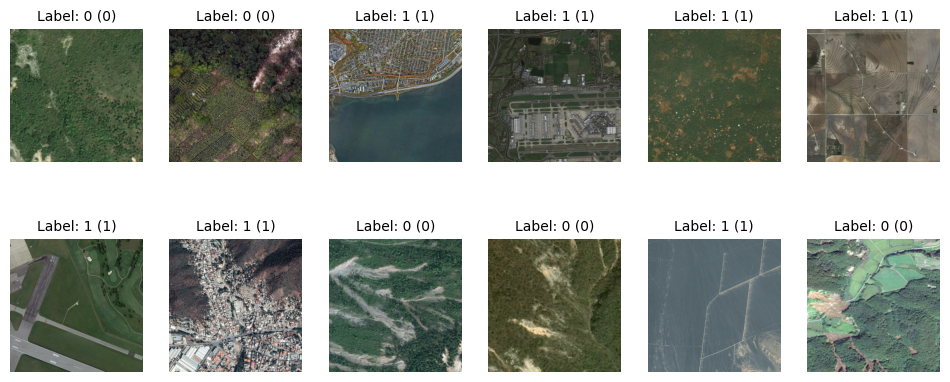

In [16]:
## Checking Images and Labels:
plt.figure(figsize=(12, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(12):  # Display first 6 samples
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

**<span style="color:#180842; font-size:26px">
Set Test Data
</span>** <br>

In [17]:
## Update path given the Google_Earth_Images/landslide vs. non-landslide directory structure. 
data_dir_test_lvltwo=pathlib.Path(data_dir_test) #/ 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted')

In [18]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=614,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 62 files belonging to 2 classes.


In [19]:
## Review class names based on dataset. 
class_names = test_dataset.class_names
print(class_names)

['landslides', 'non-landslides']


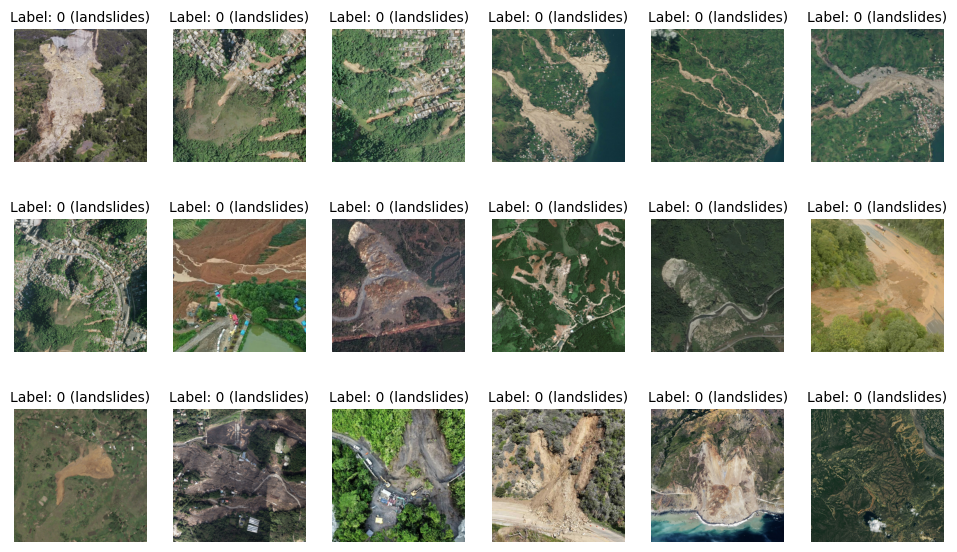

In [20]:
## Checking the Labels. 
plt.figure(figsize=(12, 7))
for images, labels in test_dataset.take(1):  # Take one batch
    for i in range(18):  # Display first 6 samples
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [21]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.1375234521575985, 1: 0.8921424367274867}


<hr style="border:8px solid #301b66">

### **Helper Functions**

In [22]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Saturation
- The saturation factor is sampled randomly from a uniform distribution in the range [lower, upper].
- A saturation factor of 1.0 means no change in saturation.
- A saturation factor below 1.0 decreases the saturation (the image will appear less vibrant or more grayscale).
- A saturation factor above 1.0 increases the saturation (the image will appear more vibrant).

#### **Augmentation**

In [39]:
### Data Augmentation Helper
# data_augmentation = keras.Sequential(
#   [
#     keras.layers.RandomRotation(factor=0.10),
#     keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     keras.layers.RandomFlip("horizontal"),
#     keras.layers.RandomContrast(factor=0.5),
#     keras.layers.RandomBrightness(factor=.6),
      
#     # layers.RandomSaturation(.7, seed=516) ## Error
#     keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
#   ]
# )
@keras.saving.register_keras_serializable()
class RandomSaturationLayer(keras.layers.Layer):
    def __init__(self, lower = 0.5, upper=1.3,**kwargs):
        super().__init__(**kwargs)
        self.lower = lower
        self.upper = upper
    def call(self, inputs, training = None):
        if training:
            return tf.image.random_saturation(inputs, self.lower, self.upper)
        else:
            return inputs
    def get_config(self):
        config = super().get_config().copy()
        config.update({"lower": self.lower, "upper": self.upper})
        return config

data_augmentation = keras.Sequential(
  [
    keras.layers.Input((350, 350, 3)),
    keras.layers.RandomRotation(factor=0.40),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect"),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomCrop(300, 300),
    keras.layers.RandomContrast(factor=0.6), ## Values closer to 0 = minimal adjustment, higher to 1.0 allow larger contrast variations.
    keras.layers.RandomBrightness(factor=.6),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    #keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.5, upper=1.3))
    RandomSaturationLayer(lower=0.5,upper=1.3)
  ]
)

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Model Design w/ Transfer Learning
</span>** <br>


Pre-Training with EfficientNet
- Strengths: EfficientNet models scale well in terms of parameters and efficiency, balancing accuracy with computational cost, which is especially useful for large datasets.
- Suitability: EfficientNet performs exceptionally well on high-resolution images, which is ideal for detecting fine details in satellite images.
- https://viso.ai/deep-learning/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

**Setting up EfficientNet**
- Note - using B3 as this is set up for 300x300 images. 

In [40]:
## Calc. the number of classes. 
land_class_num = len(folders)
print(f'Number of classes detected: {land_class_num}') ## Check class number AND use as argument below.

Number of classes detected: 2


In [41]:
# Setting up parameters for model. 
IMG_SIZE = 350
learn_rate_land = 1e-4  ## For optimizer.

<hr style="border:3px solid #301b66">

## **Model**

### **Define Model Design**

In [42]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes, learning_r):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
       
    ### Adding Augmentation
    augmented_inputs = data_augmentation(inputs)  ## Added Line
    
    ### Add a rescaling layer to normalize pixel values to range [0, 1] !! Note-this caused a large decrease in performance...
    # normalized_inputs = Rescaling(scale=1.0 / 255)(augmented_inputs)
    
    model = EfficientNetB3(include_top=False, input_tensor=augmented_inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learning_r)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

### **Build Model**

In [43]:
### Create Model
landslide_model_ENB3 = build_model(num_classes=land_class_num, learning_r=learn_rate_land)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

In [44]:
### Review of the model structure:   Confirm that no layers are open after set.
# landslide_model_ENB3.summary(show_trainable=True)

### **Fit**

In [45]:
epochs = 10  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)

Epoch 1/10
 1/95 [..............................] - ETA: 21:11 - loss: 1.0458 - accuracy: 0.4531

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


95/95 [==============================] - 31s 184ms/step - loss: 0.6418 - accuracy: 0.6977 - val_loss: 0.3977 - val_accuracy: 0.8288
Epoch 2/10
95/95 [==============================] - 14s 152ms/step - loss: 0.4009 - accuracy: 0.8273 - val_loss: 0.3051 - val_accuracy: 0.8606
Epoch 3/10
95/95 [==============================] - 14s 152ms/step - loss: 0.3467 - accuracy: 0.8496 - val_loss: 0.2693 - val_accuracy: 0.8728
Epoch 4/10
95/95 [==============================] - 14s 152ms/step - loss: 0.3079 - accuracy: 0.8732 - val_loss: 0.2365 - val_accuracy: 0.8887
Epoch 5/10
95/95 [==============================] - 14s 153ms/step - loss: 0.3050 - accuracy: 0.8699 - val_loss: 0.2087 - val_accuracy: 0.8999
Epoch 6/10
95/95 [==============================] - 15s 153ms/step - loss: 0.2732 - accuracy: 0.8864 - val_loss: 0.1949 - val_accuracy: 0.9102
Epoch 7/10
95/95 [==============================] - 15s 153ms/step - loss: 0.2569 - accuracy: 0.8951 - val_loss: 0.1801 - val_accuracy: 0.9196
Epoch 8/10

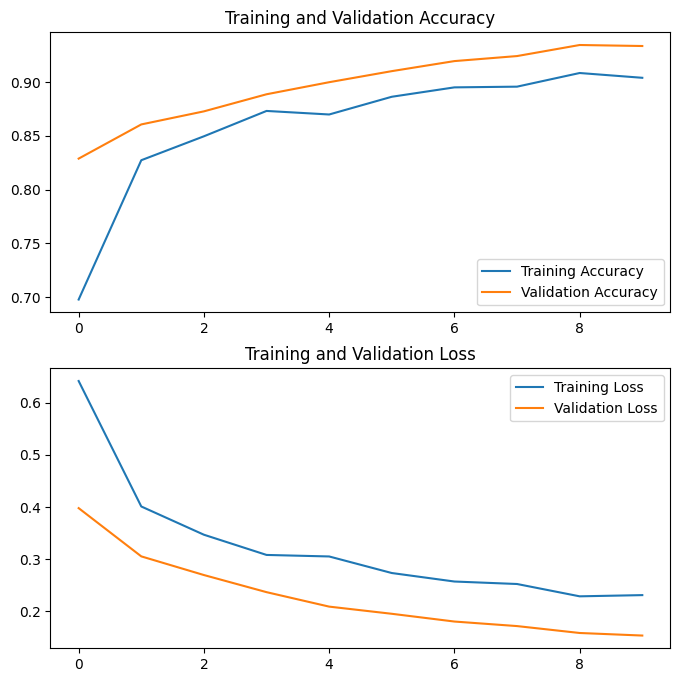

In [46]:
## Plot results
visualize_model_results(landslide_ENB3_hist)

### **Testing**

In [47]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
1/1 [==============================] - 0s 303ms/step - loss: 0.7752 - accuracy: 0.6290
test loss, test acc: [0.7752215266227722, 0.6290322542190552]


In [48]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

1/1 [==============================] - 3s 3s/step


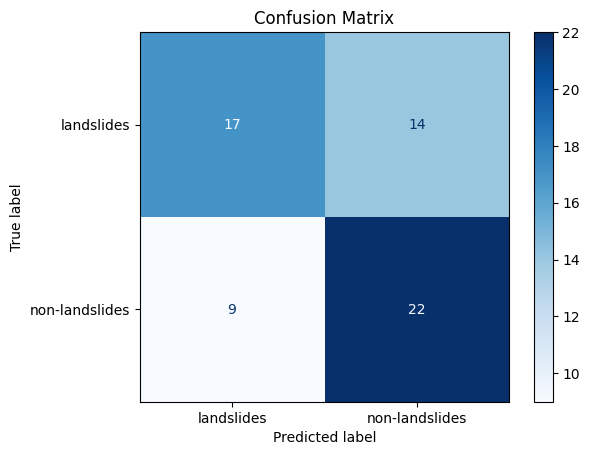

In [49]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [50]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()

print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases that are identified. {recall_val}')
specificity_val = round(TN/(TN+FP),3);
print(f'Specificity: TN / (TN + FP) | Actual negative cases that are identified. {specificity_val}')

F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 17  False Negatives (FN): 14
False Positives (FP): 9 True Negatives (TN): 22


Accuracy: 0.629
Precision: TP / (TP + FP) | Positive predictions are correct. 0.654
Recall: TP / (TP + FN) | Actual positive cases that are identified. 0.548
Specificity: TN / (TN + FP) | Actual negative cases that are identified. 0.71
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.596


### Identify Image File to Prediction|True Labels

In [61]:
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Get predictions
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

test_file_for_grad_cam_before_fine = []
print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")
        test_file_for_grad_cam_before_fine.append(file_path)


1/1 [==============================] - 0s 145ms/step

Images with predicted and true labels:
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/22_02-Petropolis-4-1024x673.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/22_02-Petropolis-5-1024x738.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/23_05-Kivu-1-768x768.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/North_Petropolis_Brazil_20220217_104400_ssc18_Flooding_rgb_3840-by-2160_50cm-1024x576.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/Screen Shot 2024-12-06 at 12.14.01 PM.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/Screen Shot 2024-12-06 at 12.15.57 PM.jpg, Predicted: 1

In [62]:
landslide_model_ENB3.save("ENB3_One_40Lyr_hh_before_fine_tuning.keras")

<hr style="border:15px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Fine Tuning - Opening Up Feature Layers
</span>** <br>

### **Number of Layers**

In [66]:
# Freeze all layers
for layer in landslide_model_ENB3.layers:
    layer.trainable = False

In [67]:
## Number of Layers to Open!!!
layer_open = 30
layer_open

30

In [68]:
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  

<hr style="border:3px solid #301b66">

### **Rebuild**

In [69]:
## Rebuild model with XX Layers open for Fine Tuning.
unfreeze_model(landslide_model_ENB3, layer_open)

In [41]:
### Review of the model structure:   Confirm that no layers are open after set.
# landslide_model_ENB3.summary(show_trainable=True)

## **Fit Model** 

In [70]:
unfreeze_model(landslide_model_ENB3, layer_open)

# epochs = 10  # @param {type: "slider", min:4, max:10}
# EFB3_hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

epochs = 10  # @param {type: "slider", min:8, max:80}
ENB3_hist_fine = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)


Epoch 1/10


2024-12-07 15:34:54.352715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1026] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx8

 2/95 [..............................] - ETA: 14s - loss: 0.1511 - accuracy: 0.9297  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


95/95 [==============================] - 34s 207ms/step - loss: 0.2076 - accuracy: 0.9108 - val_loss: 0.1061 - val_accuracy: 0.9588
Epoch 2/10
95/95 [==============================] - 15s 161ms/step - loss: 0.1586 - accuracy: 0.9335 - val_loss: 0.0942 - val_accuracy: 0.9598
Epoch 3/10
95/95 [==============================] - 15s 162ms/step - loss: 0.1417 - accuracy: 0.9423 - val_loss: 0.0729 - val_accuracy: 0.9757
Epoch 4/10
95/95 [==============================] - 15s 161ms/step - loss: 0.1234 - accuracy: 0.9484 - val_loss: 0.0700 - val_accuracy: 0.9738
Epoch 5/10
95/95 [==============================] - 15s 162ms/step - loss: 0.1217 - accuracy: 0.9518 - val_loss: 0.0616 - val_accuracy: 0.9794
Epoch 6/10
95/95 [==============================] - 15s 162ms/step - loss: 0.1061 - accuracy: 0.9570 - val_loss: 0.0485 - val_accuracy: 0.9869
Epoch 7/10
95/95 [==============================] - 15s 163ms/step - loss: 0.0990 - accuracy: 0.9599 - val_loss: 0.0738 - val_accuracy: 0.9682
Epoch 8/10

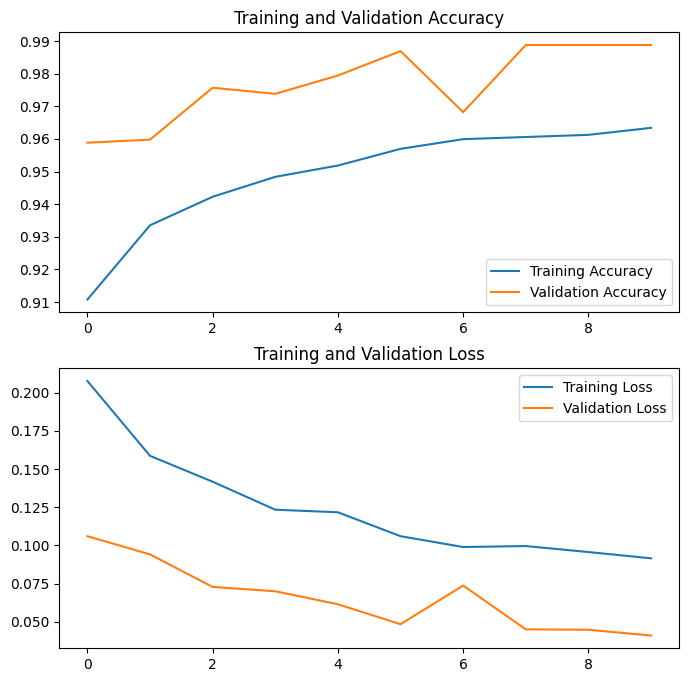

In [71]:
## Plot results
visualize_model_results(ENB3_hist_fine)

## **Testing**

In [72]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
1/1 [==============================] - 0s 318ms/step - loss: 0.7592 - accuracy: 0.7097
test loss, test acc: [0.7591732144355774, 0.7096773982048035]


In [73]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

1/1 [==============================] - 3s 3s/step


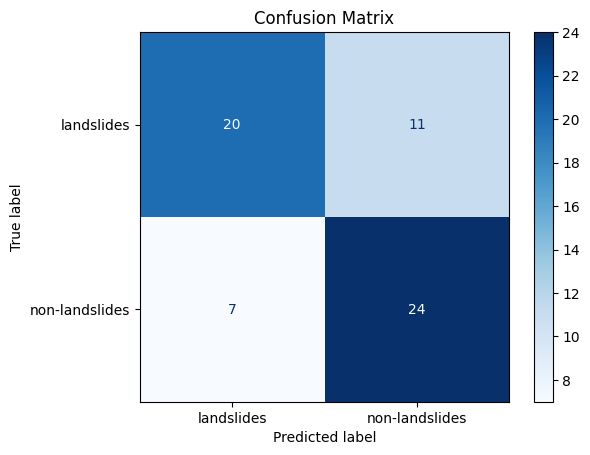

In [74]:
## Confusion Matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [75]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()

print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases that are identified. {recall_val}')
specificity_val = round(TN/(TN+FP),3);
print(f'Specificity: TN / (TN + FP) | Actual negative cases that are identified. {specificity_val}')

F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 20  False Negatives (FN): 11
False Positives (FP): 7 True Negatives (TN): 24


Accuracy: 0.71
Precision: TP / (TP + FP) | Positive predictions are correct. 0.741
Recall: TP / (TP + FN) | Actual positive cases that are identified. 0.645
Specificity: TN / (TN + FP) | Actual negative cases that are identified. 0.774
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.69


### Identify Image File to Prediction|True Labels

In [76]:
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Get predictions
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels
test_file_for_grad_cam_after_fine = []
print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")
        test_file_for_grad_cam_after_fine.append(file_path)

1/1 [==============================] - 0s 158ms/step

Images with predicted and true labels:
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/22_02-Petropolis-4-1024x673.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/22_02-Petropolis-5-1024x738.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/23_05-Kivu-2-768x576.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/North_Petropolis_Brazil_20220217_104400_ssc18_Flooding_rgb_3840-by-2160_50cm-1024x576.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/Screen Shot 2024-12-06 at 12.15.57 PM.jpg, Predicted: 1, True Label: 0
File: /home/rrm3nh/.keras/datasets/google_earth_unique_test_extracted/landslides/Screen Shot 2024-12-06 at 12.33.58 PM.jpg, Predicted: 1

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Train Model on Full Population
</span>** <br>

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Saving Model for Future Use
</span>** <br>

In [77]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
# model.save("my_model.keras")
landslide_model_ENB3.save("ENB3_One_40Lyr_hh_after_fine_tuning.keras")

**<span style="color:#0638b2; font-size:30px">
Gradcam
</span>** <br>

In [53]:
from tensorflow.keras.preprocessing import image
import cv2
from tensorflow.keras import models
from IPython.display import Image, display
import matplotlib as mpl

#model = tf.keras.models.load_model('/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_40Lyr_hh.keras')
#conv_layer = model.get_layer('top_conv') 


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


#def get_img_array(img_path, size=(300, 300)):
    # Load image
#    img = load_img(img_path, target_size=size)
#    img_array = img_to_array(img)  # Convert image to array
#    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#    return img_array

def grad_cam(model, image, conv_layer_name):
    # Create a model that gives both the convolutional layer output and the final predictions
    grad_model = models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )
    
    # Compute gradients with respect to the predicted class
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(image)
        inputs = tf.image.resize(inputs, (224, 224))  
        tape.watch(inputs)
        
        conv_output, predictions = grad_model(inputs)
        predicted_class = tf.argmax(predictions[0])  # Get the class with the highest probability
        
    grads = tape.gradient(predictions[0][0, predicted_class], conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Pool gradients across all axes
    
    # Multiply the feature map by the gradients to get the weighted feature map
    conv_output = conv_output[0]
    for i in range(pooled_grads.shape[-1]):
        conv_output[..., i] *= pooled_grads[i]
    
    # Create the heatmap by summing along the depth axis (channels)
    heatmap = tf.reduce_sum(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)  
    heatmap /= np.max(heatmap) 
    
    return heatmap


def make_gradcam_heatmap(img_array, model, last_conv_layer_name,last_deep_layer_name,pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.get_layer(last_deep_layer_name).output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



In [55]:
def overlay_heatmap(heatmap, image, alpha=0.4, cam_path="cam.jpg"):
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply a color map to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose the heatmap onto the original image
    superimposed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    
    # Save the superimposed image
    cv2.imwrite(cam_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))  # Save as BGR for OpenCV

    # Display Grad-CAM
    display(Image(cam_path))
    
    return superimposed_img

In [54]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [78]:
landslide_model_ENB3_before = keras.models.load_model("ENB3_One_40Lyr_hh_before_fine_tuning.keras",custom_objects={"RandomSaturationLayer": RandomSaturationLayer})
landslide_model_ENB3_after = keras.models.load_model("ENB3_One_40Lyr_hh_after_fine_tuning.keras",custom_objects={"RandomSaturationLayer": RandomSaturationLayer})

In [64]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
last_conv_layer_name = "top_conv" #take the last convolutional layer
last_deep_layer_name = "top_dropout"



## Grad CAM Before Tuning
### Images used: Actual landslides but predicted as non-landslides

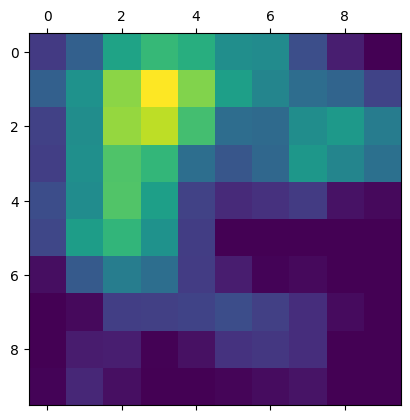

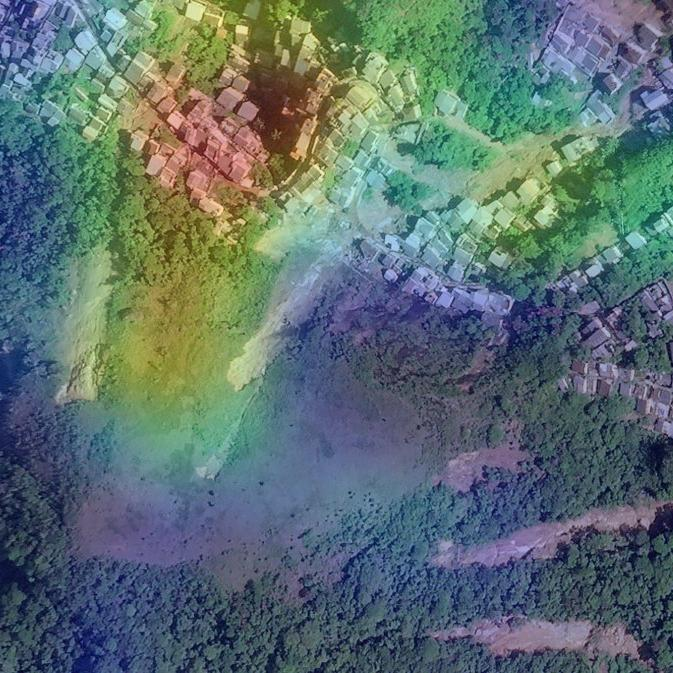

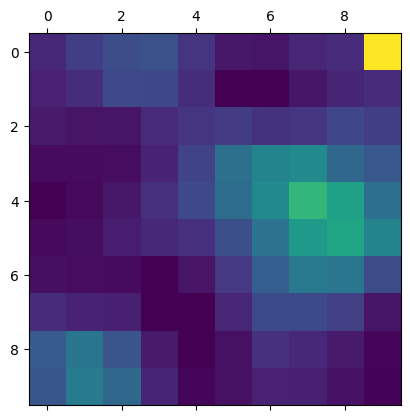

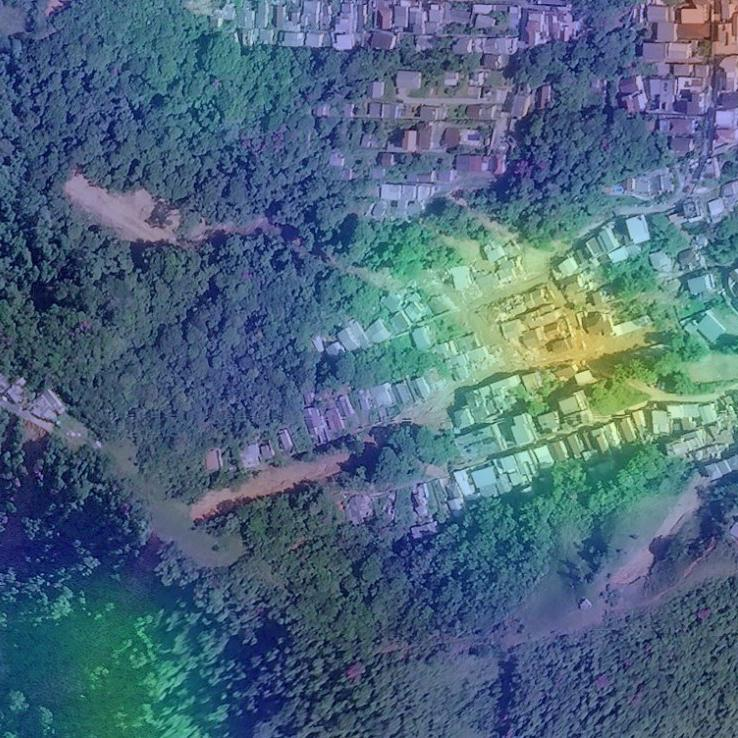

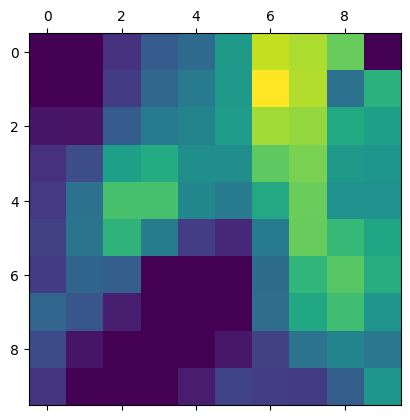

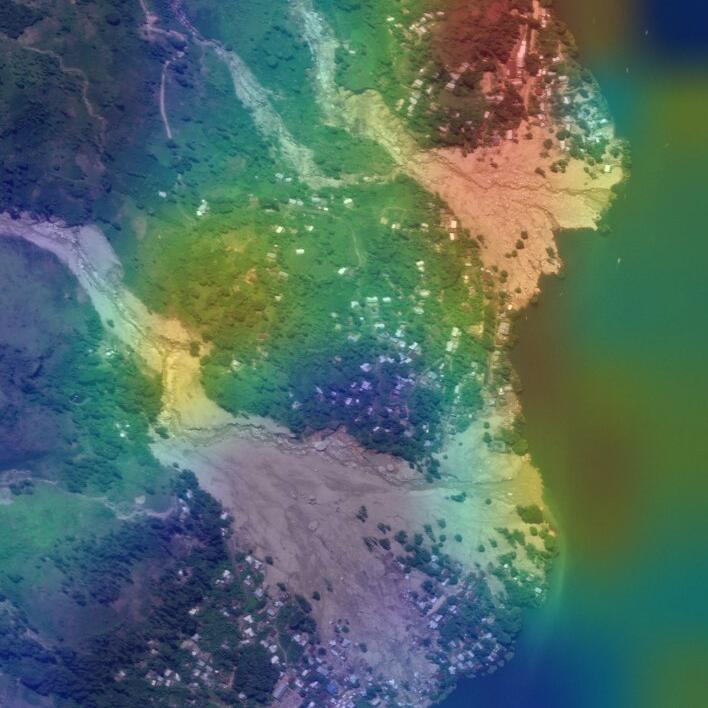

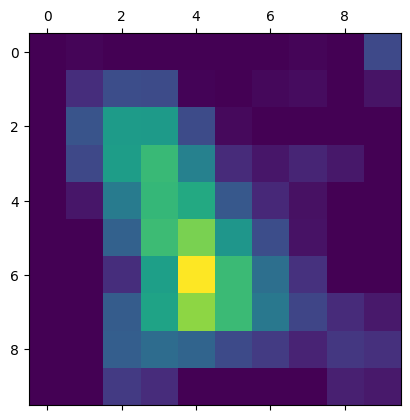

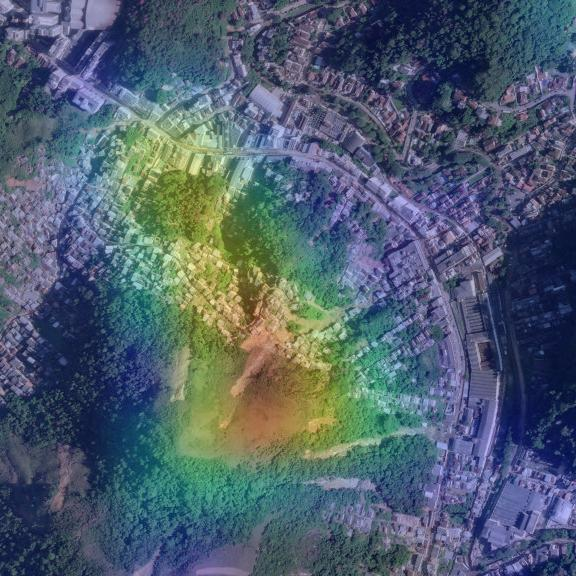

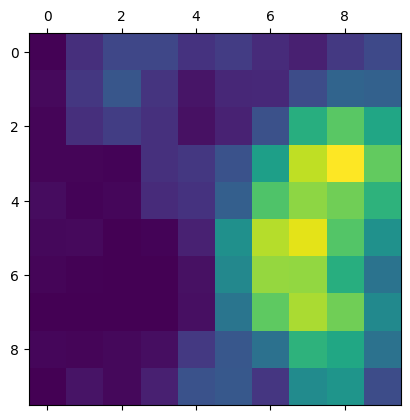

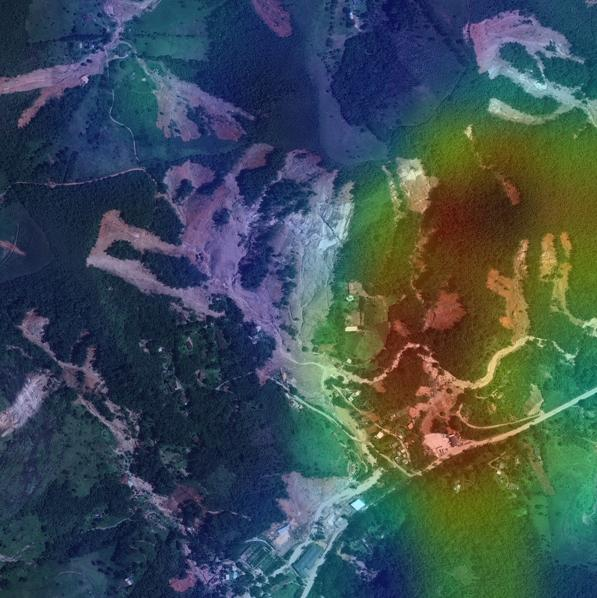

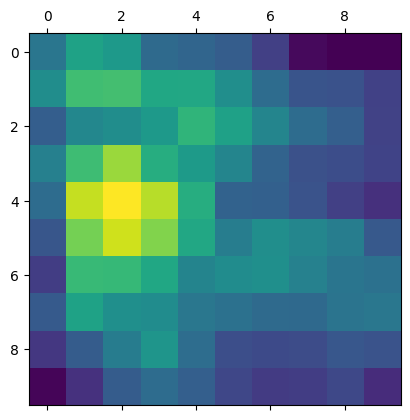

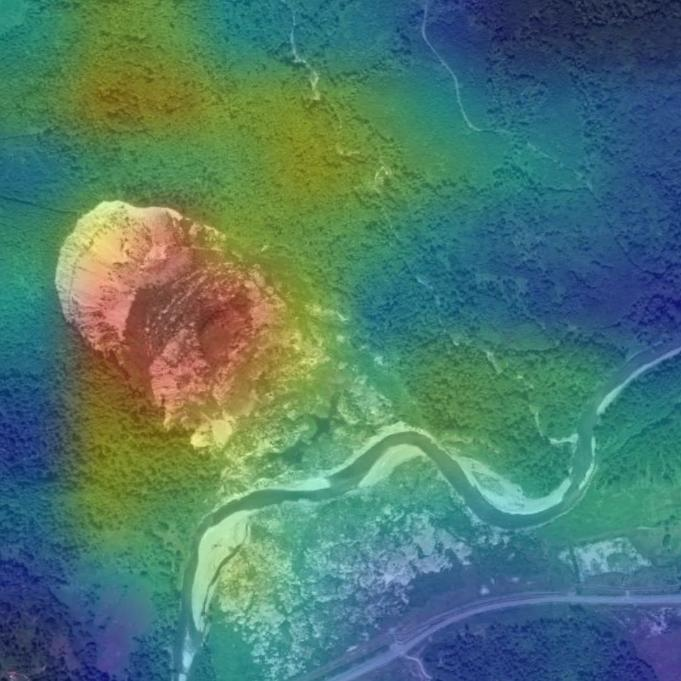

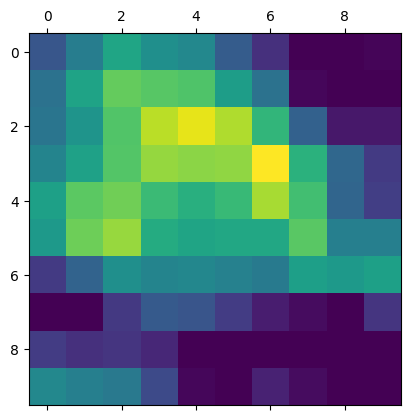

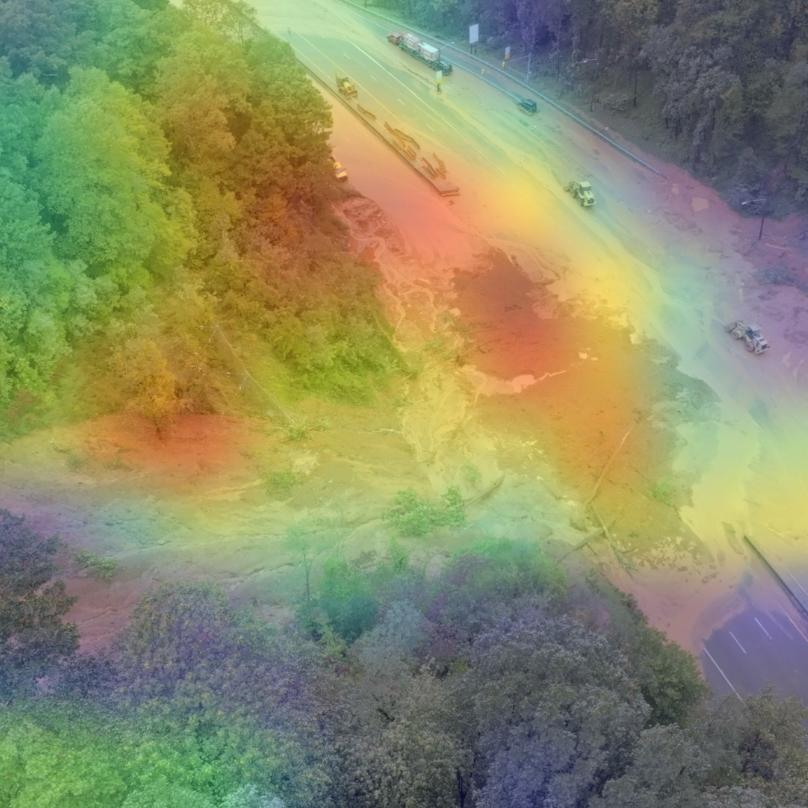

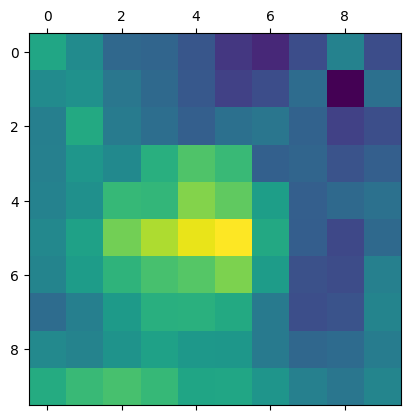

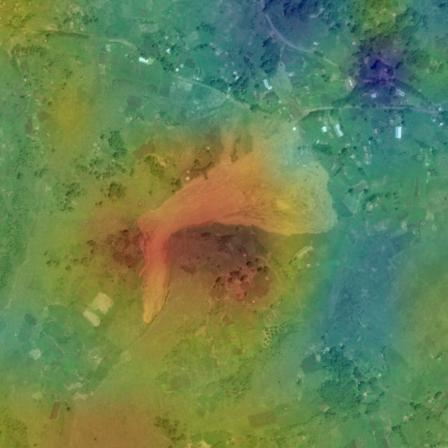

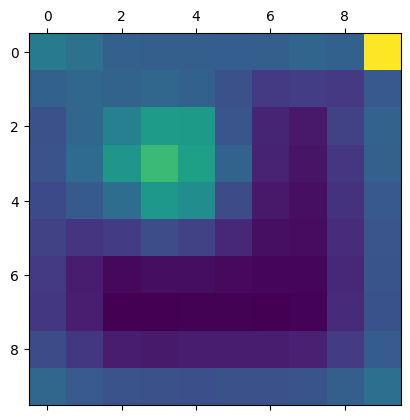

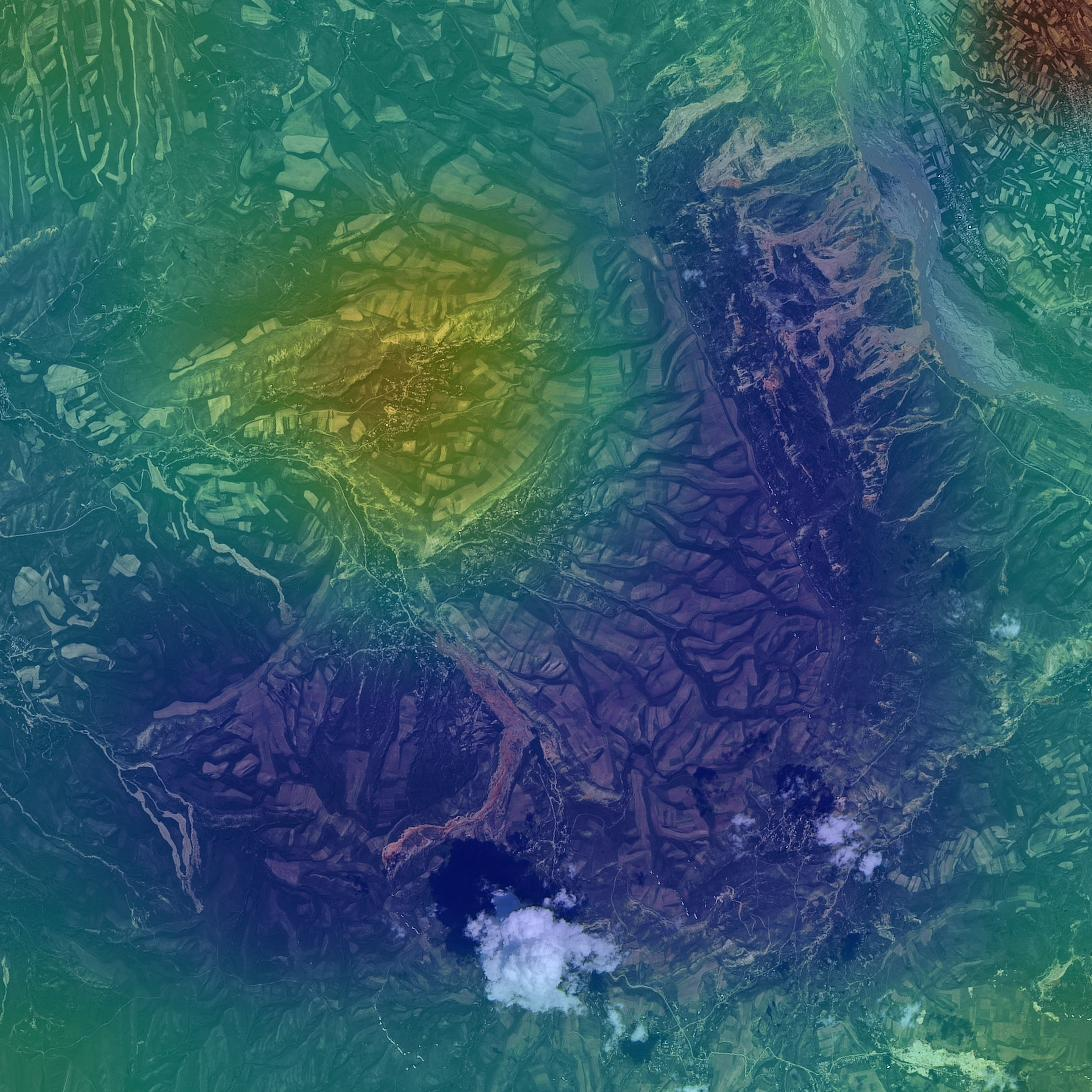

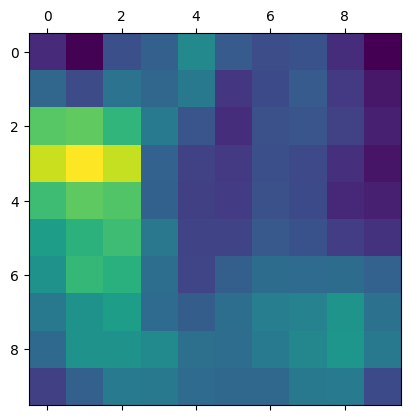

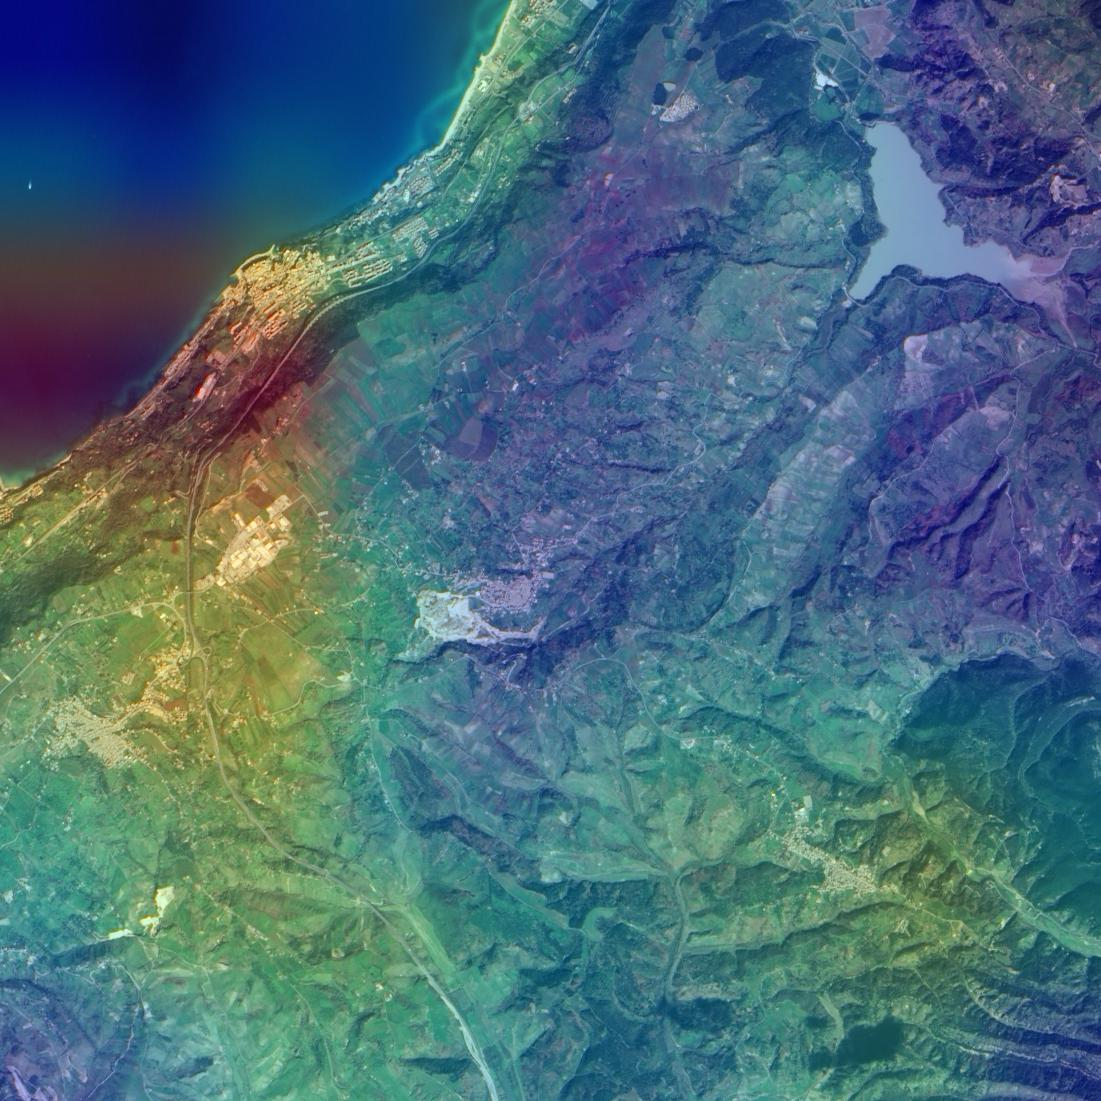

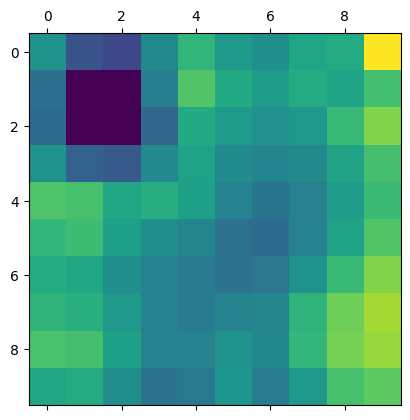

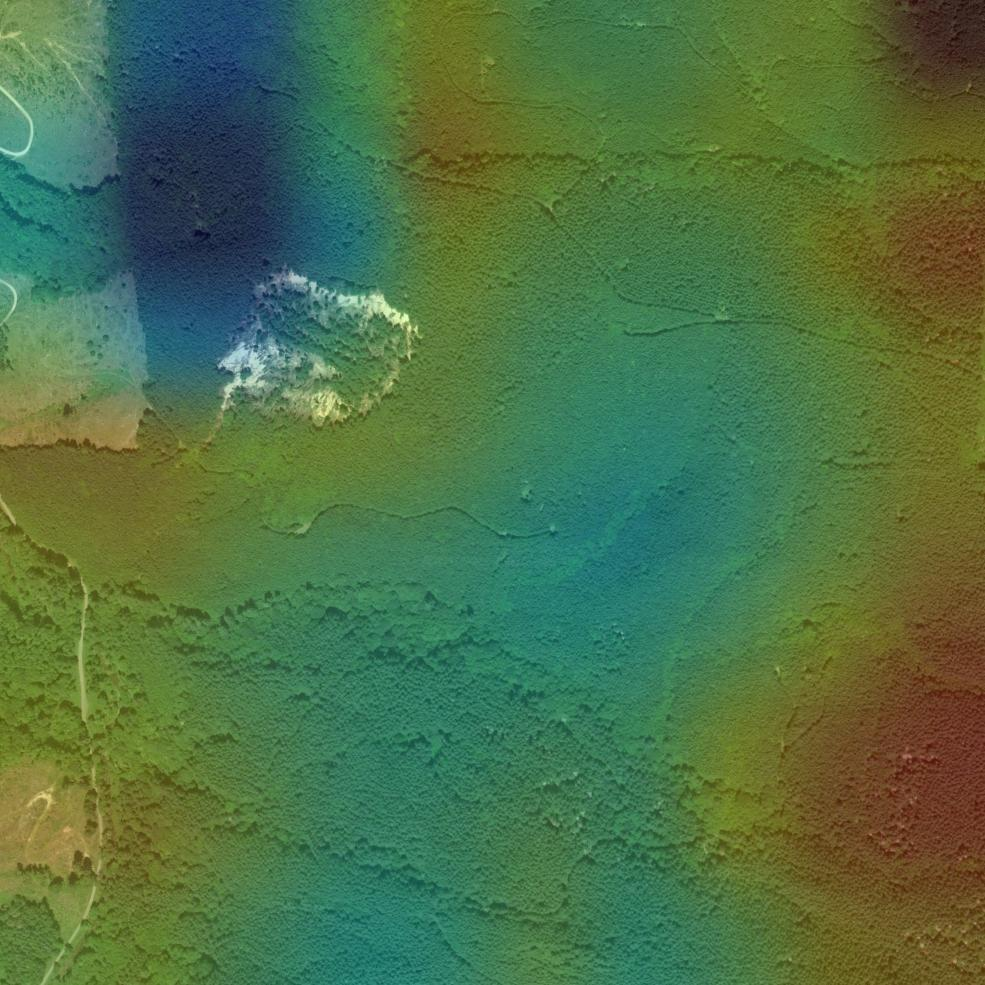

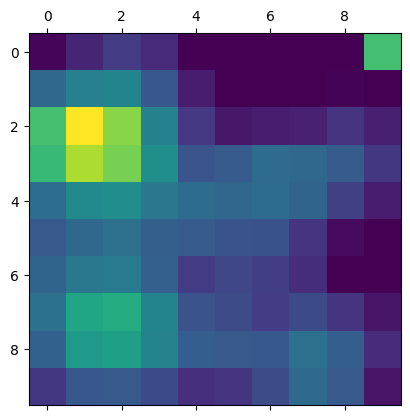

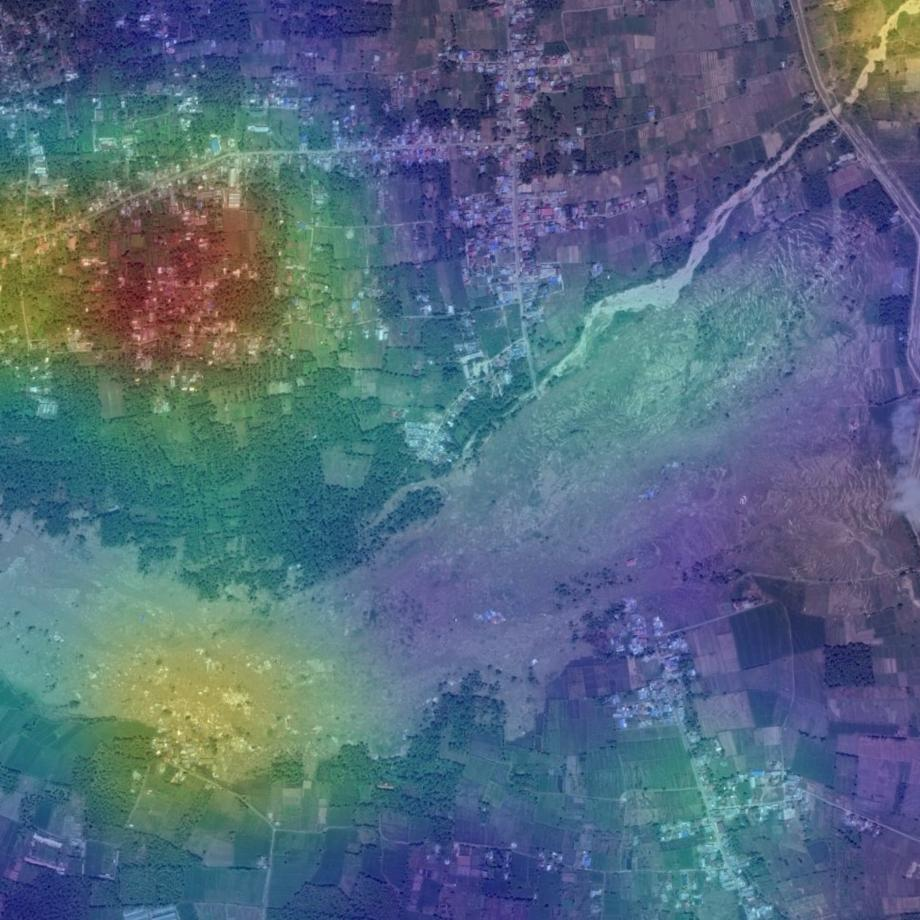

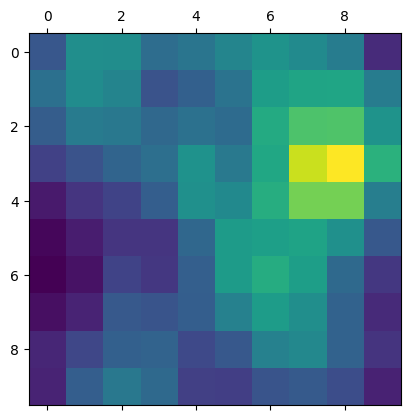

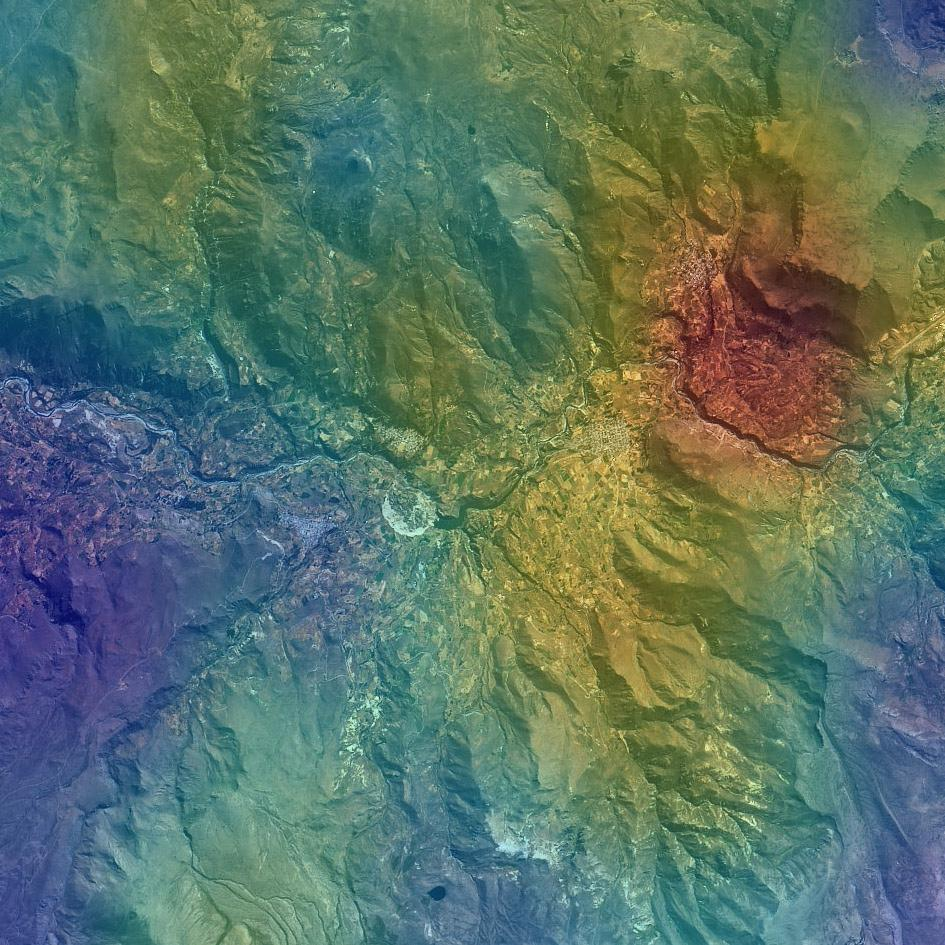

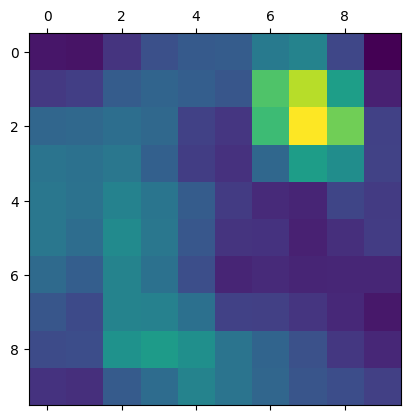

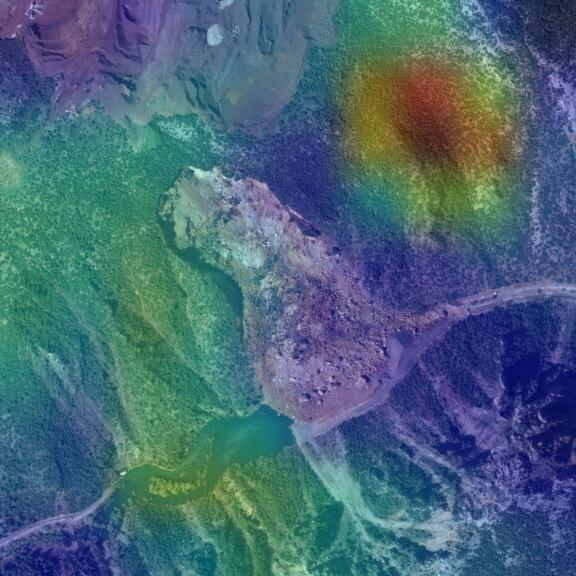

In [65]:
img_size = (350, 350)


for incorrect in test_file_for_grad_cam_before_fine:
    img_array = tf.keras.applications.efficientnet.preprocess_input(get_img_array(incorrect, size=img_size))

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, landslide_model_ENB3_before, last_conv_layer_name, last_deep_layer_name)

    # Display the heatmap
    plt.matshow(heatmap)
    plt.show()
    # Adjust the image preprocessing based on your model
    save_and_display_gradcam(incorrect, heatmap)

## Grad CAM after Tuning
### Images used: Actual landslides but predicted as non-landslides

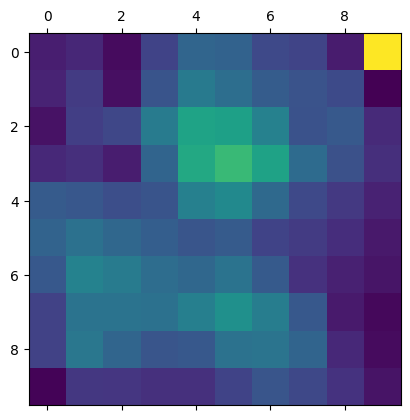

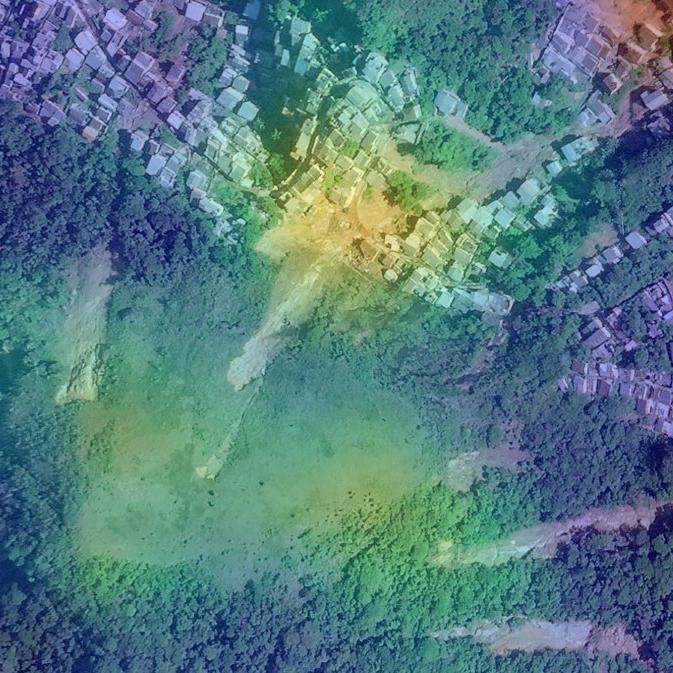

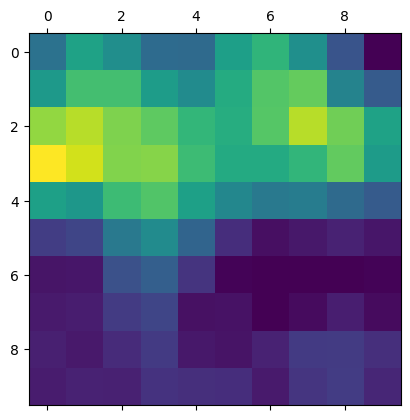

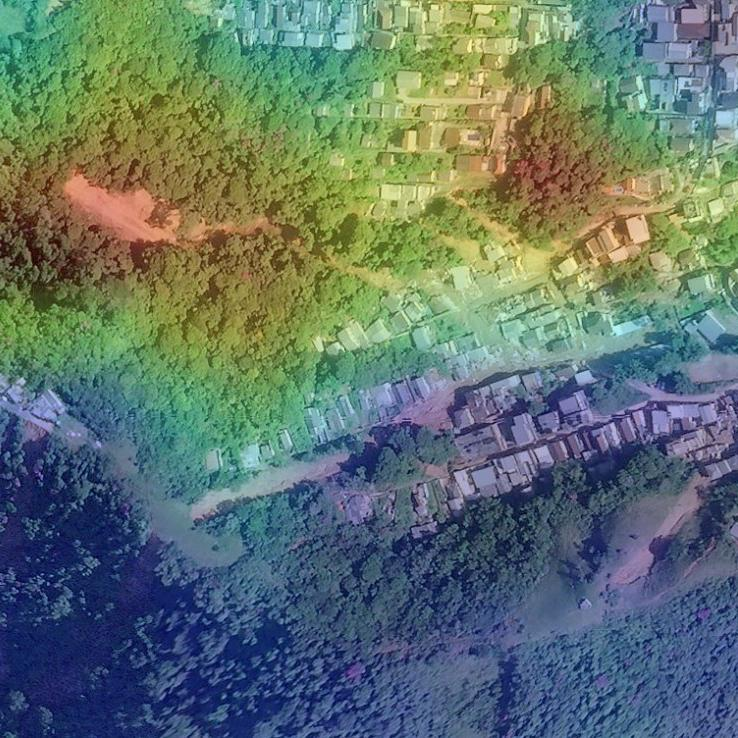

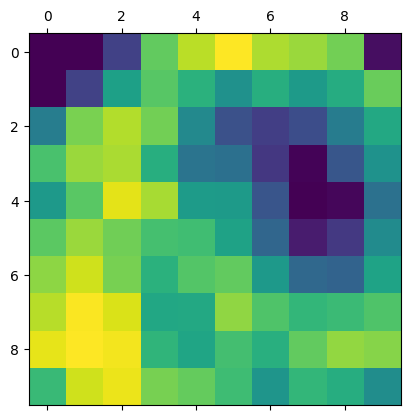

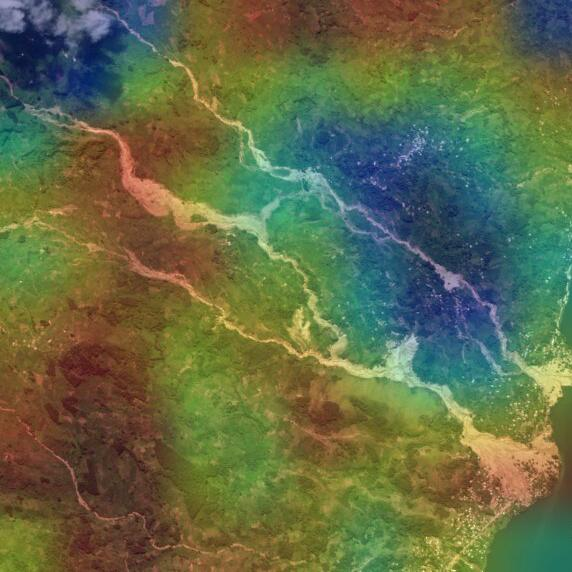

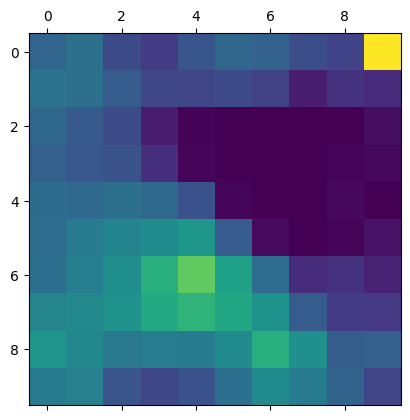

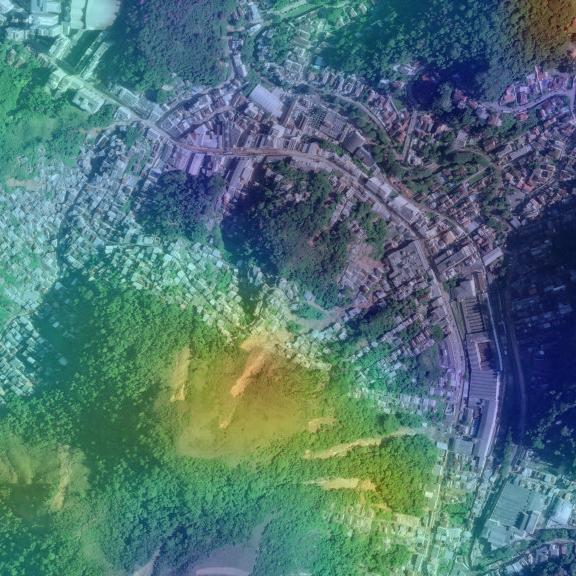

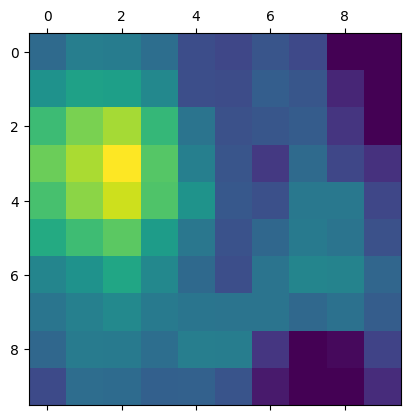

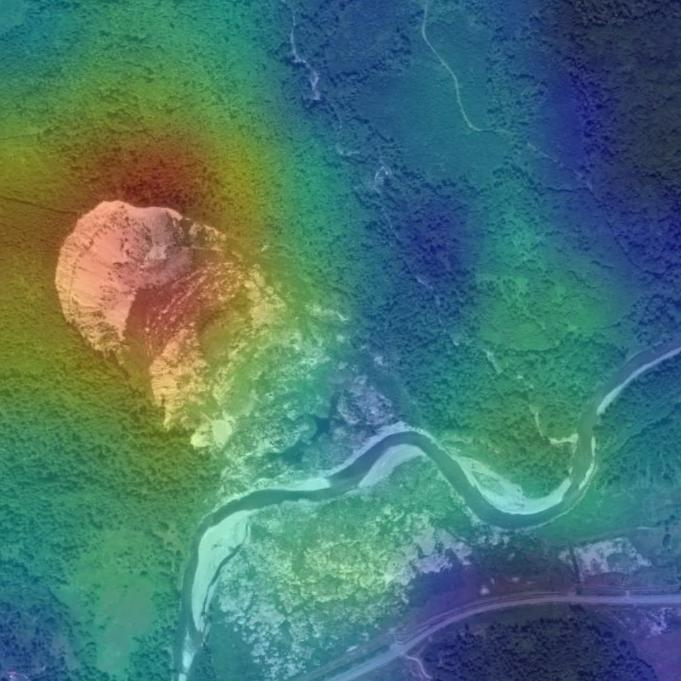

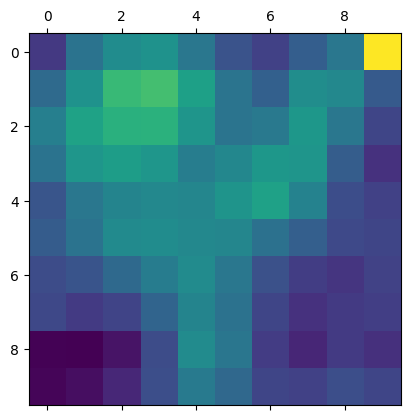

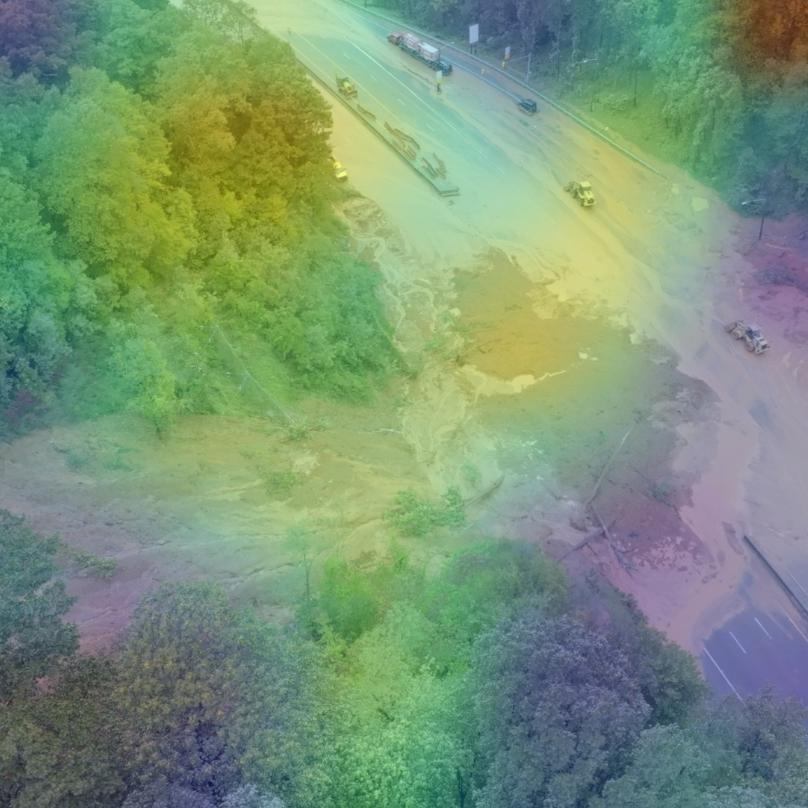

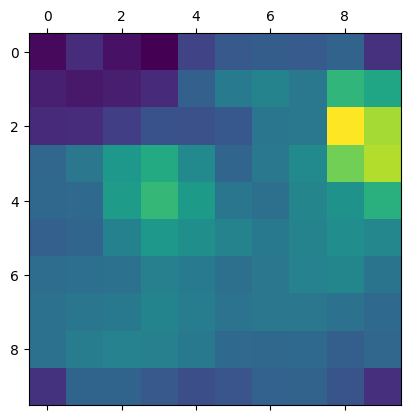

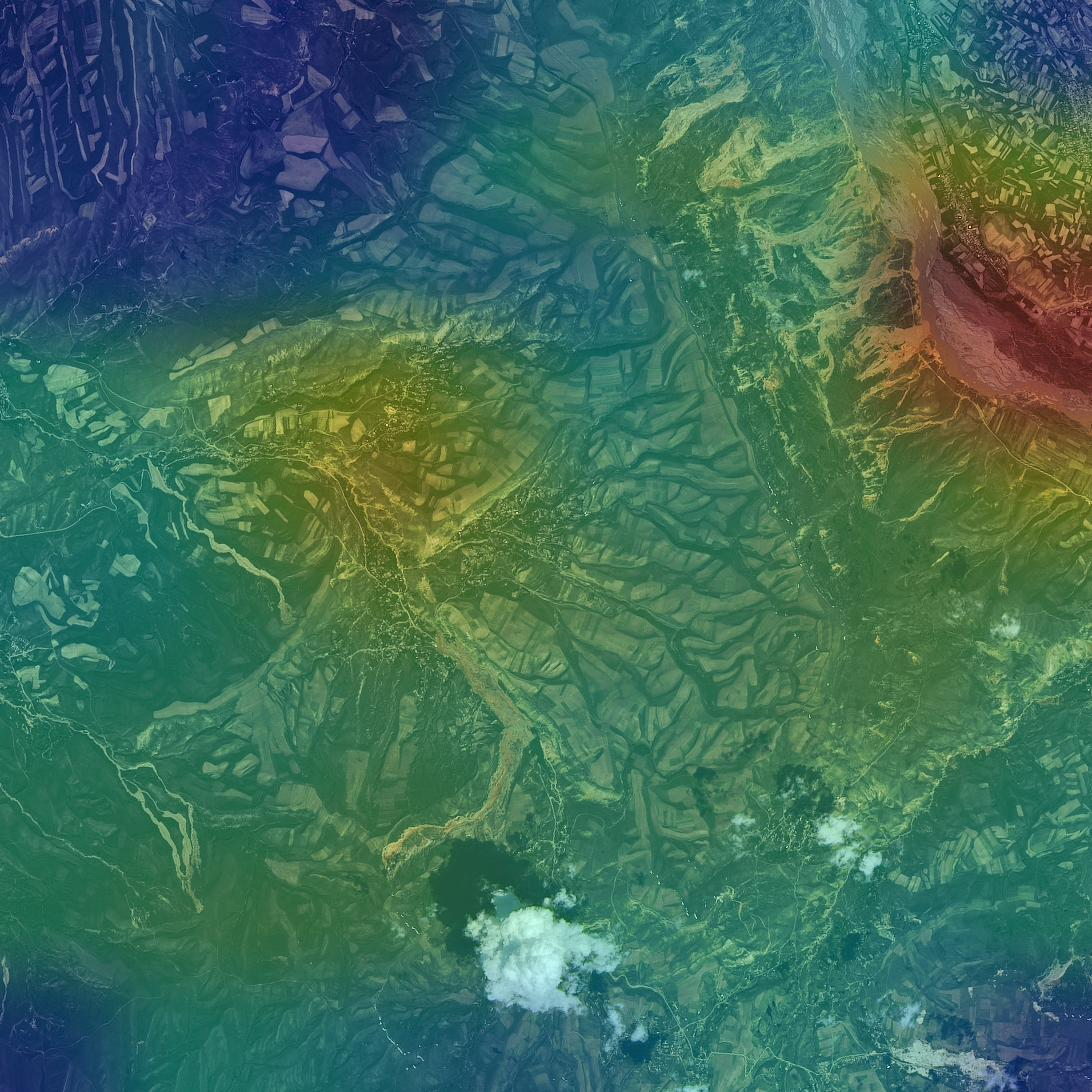

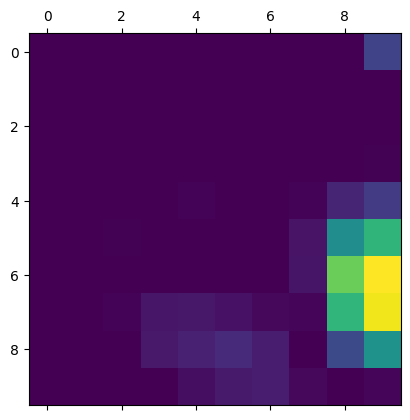

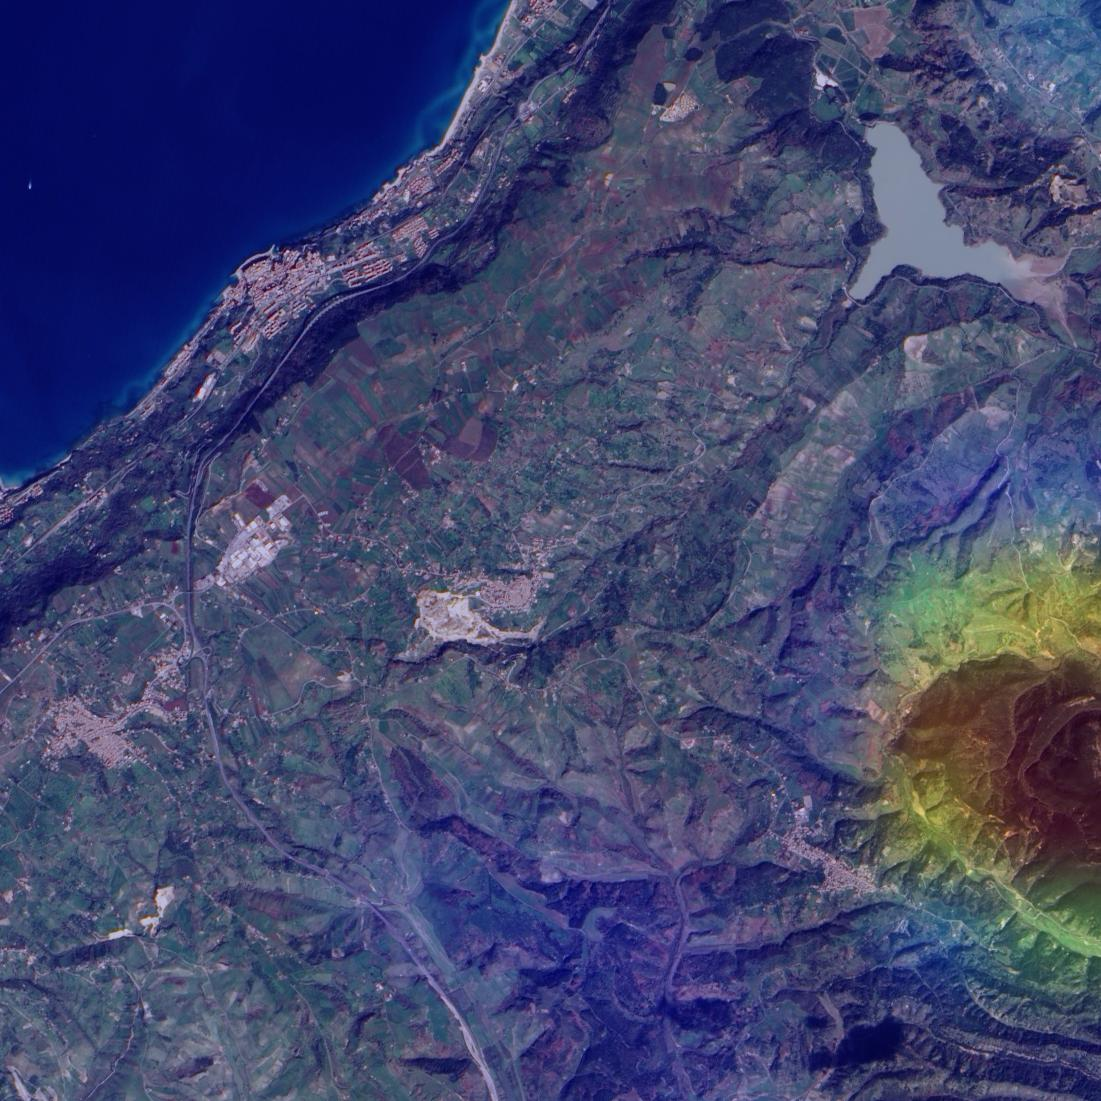

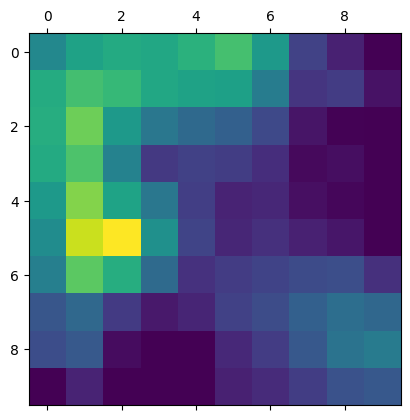

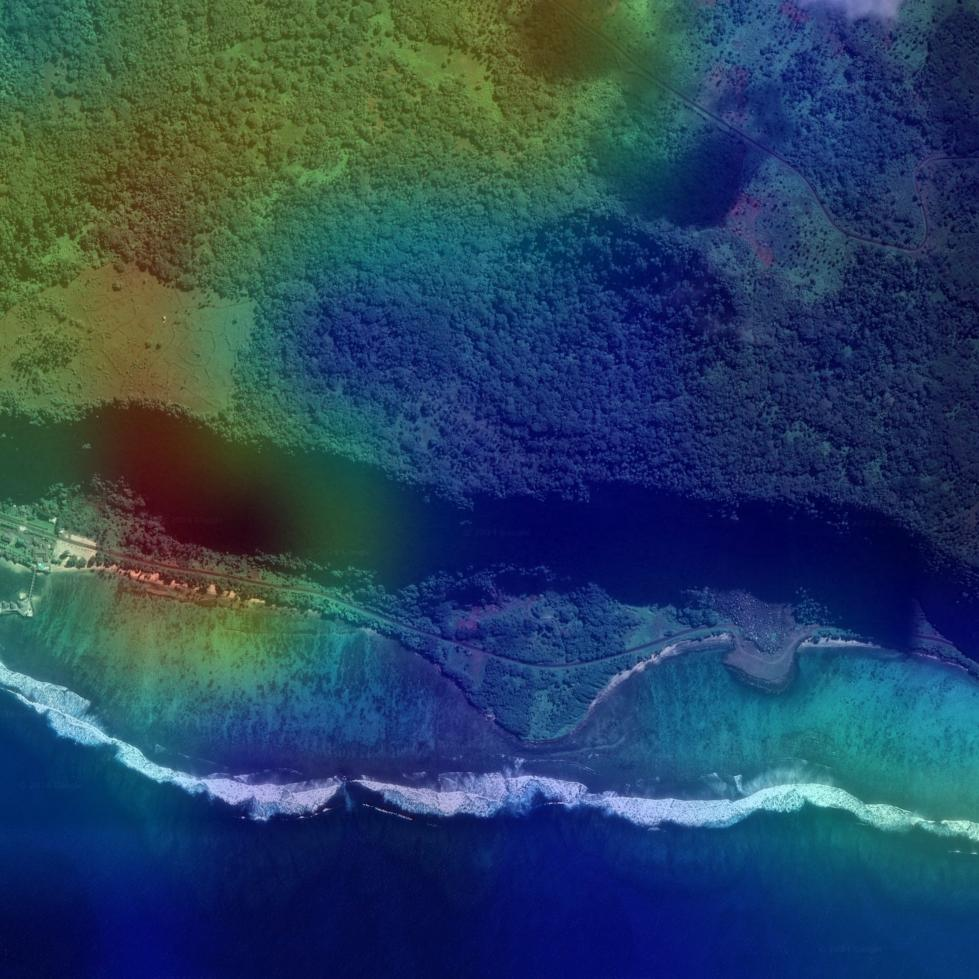

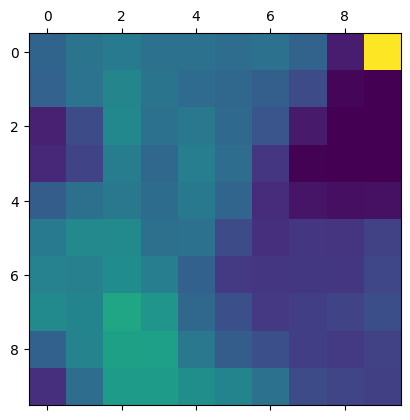

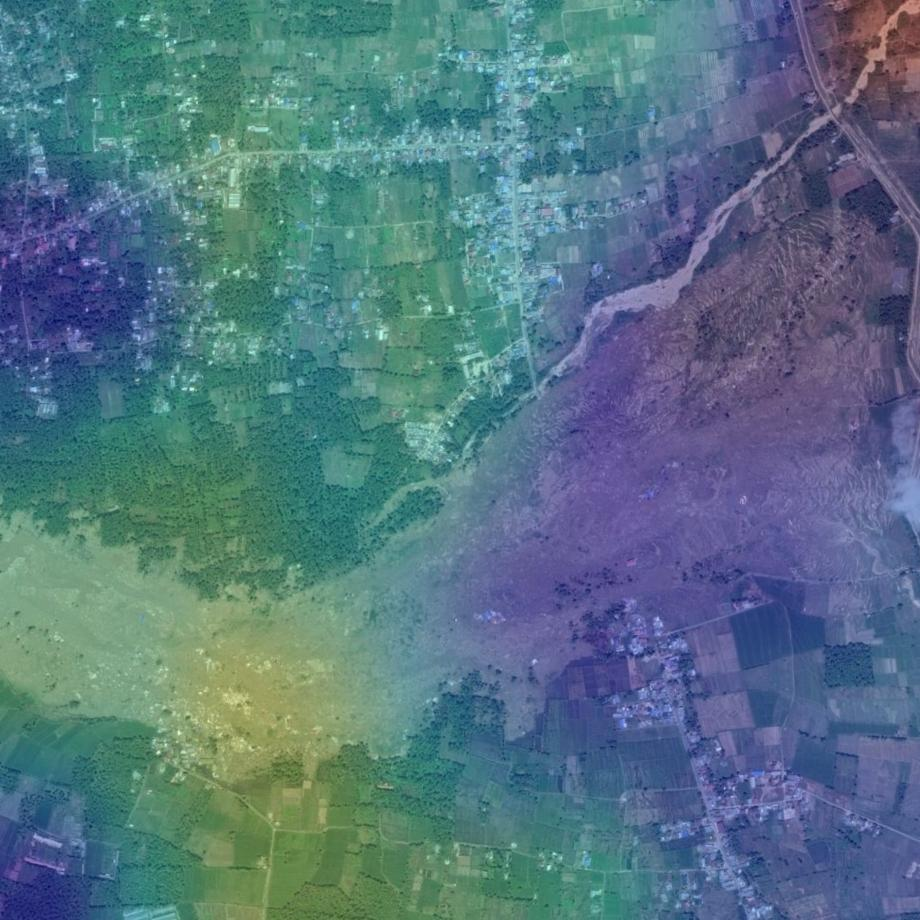

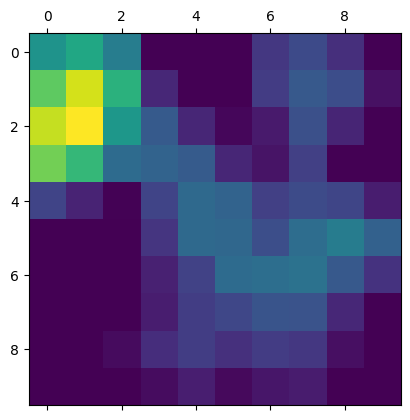

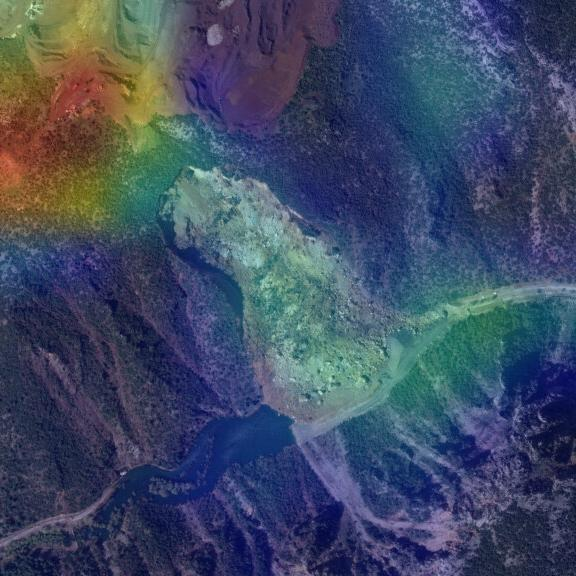

In [79]:
img_size = (350, 350)


for incorrect in test_file_for_grad_cam_after_fine:
    img_array = tf.keras.applications.efficientnet.preprocess_input(get_img_array(incorrect, size=img_size))

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, landslide_model_ENB3_after, last_conv_layer_name, last_deep_layer_name)

    # Display the heatmap
    plt.matshow(heatmap)
    plt.show()
    # Adjust the image preprocessing based on your model
    save_and_display_gradcam(incorrect, heatmap)